# Analysis of Stream Gauges

This code was created to calculate slopes and perform our drought analysis on each individual wells used in this study.

To run this code, you need to follow all of the DataPreprocessing instructions.

Total time to run on my machine: TBA

In [1]:
# Packages and paths

import os
import numpy as np
import pandas as pd
#import earthpy as et
import scipy.stats as sp
import geopandas as gp
import matplotlib.pyplot as plt

# Local paths
# inputpath = '../../Data/Input/RawData'
inputpath = '../../Data/Input'
outputpath = '../../Data/Output/Local'

# Function to calculate slope using linear regression
def calculate_slope(y):
    x = np.arange(len(y))
    slope, _ = np.polyfit(x, y, 1)
    return slope

In [25]:
# ==== Reading in the data ====
filename_ts = 'USGS_Streamgauges'
# filename_ts = 'USGS_Streamgauges_19801999'
filepath = os.path.join(inputpath, filename_ts)

# Open the file and read the first 10 lines
print("Supplemental Information about this file:")
with open(filepath, 'r') as file:
    for i in range(301):
        print(file.readline().strip())

# stream_db = pd.read_csv(filepath, sep='\t',
#                         # header=300,
#                         skiprows=295,  # Adjust as needed
#                         on_bad_lines="skip"
#                     )
# stream_db

Supplemental Information about this file:
# ---------------------------------- WARNING ----------------------------------------
# Some of the data that you have obtained from this U.S. Geological Survey database
# may not have received Director's approval. Any such data values are qualified
# as provisional and are subject to revision. Provisional data are released on the
# condition that neither the USGS nor the United States Government may be held liable
# for any damages resulting from its use.
#
# Additional info: https://waterdata.usgs.gov/provisional-data-statement/
#
# Contact:   gs-w_waterdata_support@usgs.gov
# retrieved: 2024-12-29 17:02:08 EST       (nadww02)
#
# Data for the following 327 site(s) are contained in this file
#    USGS 09379025 CHINLE CREEK AT CHINLE, AZ
#    USGS 09379050 LUKACHUKAI CREEK NEAR LUKACHUKAI, AZ
#    USGS 09379180 LAGUNA CREEK AT DENNEHOTSO, AZ
#    USGS 09379200 CHINLE CREEK NEAR MEXICAN WATER, AZ
#    USGS 09379910 COLORADO RIVER BELOW GLEN CAN

In [15]:
# This is a test block to combine all the code
test = stream_db.copy()
skip_values = ['agency_cd','#','5s']
for i in skip_values:
    test = test[test['agency_cd'] != i]
test

,agency_cd,site_no,datetime,tz_cd,6121_00060,6121_00060_cd
1,USGS,09379025,1999-11-05 00:00,MST,5.00,A:[91]
2,USGS,09379025,1999-11-05 00:15,MST,5.80,A:[91]
3,USGS,09379025,1999-11-05 00:30,MST,5.80,A:[91]
4,USGS,09379025,1999-11-05 00:45,MST,5.80,A:[91]
5,USGS,09379025,1999-11-05 01:00,MST,5.80,A:[91]
...,...,...,...,...,...,...
42543876,USGS,9537200,1999-12-31 22:45,MST,0.39,A:[91]
42543877,USGS,9537200,1999-12-31 23:00,MST,0.39,A:[91]
42543878,USGS,9537200,1999-12-31 23:15,MST,0.39,A:[91]
42543879,USGS,9537200,1999-12-31 23:30,MST,0.39,A:[91]


In [16]:
# stream_db = stream_db[1:140178208]
cleaned_streamdb = test
cleaned_streamdb = cleaned_streamdb.rename(columns={"agency_cd": "Agency",
                   "site_no": "ID",
                   "6121_00060": "Discharge (cfs)"}, errors="raise")
cleaned_streamdb.head()

,Agency,ID,datetime,tz_cd,Discharge (cfs),6121_00060_cd
1,USGS,09379025,1999-11-05 00:00,MST,5.00,A:[91]
2,USGS,09379025,1999-11-05 00:15,MST,5.80,A:[91]
3,USGS,09379025,1999-11-05 00:30,MST,5.80,A:[91]
4,USGS,09379025,1999-11-05 00:45,MST,5.80,A:[91]
5,USGS,09379025,1999-11-05 01:00,MST,5.80,A:[91]


Basically when I tried to convert the date column into datetime, I noticed that metadata is being repeated for each station deep in the tables.  

In [18]:
df = cleaned_streamdb
discharge_colname = "Discharge (cfs)"
# Making sure everything is the correct types
df['datetime'] = pd.to_datetime(df.datetime)
# Convert discharge column to numeric
df[discharge_colname] = pd.to_numeric(df[discharge_colname], errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42543148 entries, 1 to 42543880
Data columns (total 6 columns):
 #   Column           Dtype         
---  ------           -----         
 0   Agency           object        
 1   ID               object        
 2   datetime         datetime64[ns]
 3   tz_cd            object        
 4   Discharge (cfs)  float64       
 5   6121_00060_cd    object        
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 2.2+ GB


In [19]:
# Extract date from datetime
df['date'] = df['datetime'].dt.date  # Only keeps the date (YYYY-MM-DD)
daily_avg = df.groupby(['ID', 'date'])[discharge_colname].mean().reset_index()
daily_avg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460878 entries, 0 to 460877
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   ID               460878 non-null  object 
 1   date             460878 non-null  object 
 2   Discharge (cfs)  460878 non-null  float64
dtypes: float64(1), object(2)
memory usage: 10.5+ MB


In [20]:
daily_avg.to_csv(outputpath+"/usgs_daily_discharge_19801999.csv")

In [21]:
# Add a zero-flow flag
daily_avg['Zero_Flow'] = daily_avg['Discharge (cfs)'].apply(lambda x: 1 if x == 0 else 0)

# Extract the year from the date
daily_avg['Year'] = pd.to_datetime(daily_avg['date']).dt.year

# Count zero-flow days per year
zero_flow_counts = daily_avg.groupby(['ID', 'Year'])['Zero_Flow'].sum().reset_index()
zero_flow_counts


,ID,Year,Zero_Flow
0,9379200,1989,0
1,9379200,1990,32
2,9379200,1991,44
3,9379200,1992,16
4,9379200,1993,30
...,...,...,...
1865,09535295,1996,336
1866,09535295,1997,312
1867,09535295,1998,183
1868,09535295,1999,133


In [22]:
# Load the stream gauge names CSV
gauge_names = pd.read_csv(inputpath+"/USGS_Gauge_Name_List.csv")

# Inspect the file to ensure it loaded correctly
print(gauge_names.head())


FileNotFoundError: [Errno 2] No such file or directory: '../../Data/Input/USGS_Gauge_Name_List.csv'

In [10]:
# del stream_db.iloc[315825]
stream_db.iloc[315810:3158228]

,Agency,ID,datetime,tz_cd,Discharge (cfs),6121_00060_cd
315811,USGS,09379025,2025-01-14 21:30,MST,0.00,P
315812,USGS,09379025,2025-01-14 21:45,MST,0.00,P
315813,USGS,09379025,2025-01-14 22:00,MST,0.00,P
315814,#,NaN,NaN,NaN,NaN,NaN
315815,# Data provided for site 09379050,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
3158224,USGS,9382000,2011-11-22 17:45,MST,9.9,A
3158225,USGS,9382000,2011-11-22 18:00,MST,10.7,A
3158226,USGS,9382000,2011-11-22 18:15,MST,9.51,A
3158227,USGS,9382000,2011-11-22 18:30,MST,11.1,A


So to account for this I ran the following pre-processing of the original stream database file and renamed it to "filtered_streamgauges_test.csv".|

In [20]:
import csv

filepath = os.path.join(inputpath, filename_ts)  # Replace with your file path
output_file = "filtered_streamgauges_test.csv"  # Adjust output file extension if needed

# Define the index of the column to check for NaN (adjust index as needed)
column_to_check = 2  # Replace with the zero-based index of the column you want to check

with open(filepath, 'r') as infile, open(output_file, 'w', newline='') as outfile:
    reader = csv.reader(infile, delimiter='\t')  # Set delimiter to tab
    writer = csv.writer(outfile, delimiter='\t')  # Set delimiter to tab

    # Skip the first 299 lines
    for _ in range(299):
        next(reader)

    # Write header (if the 300th line is the header)
    header = next(reader)
    writer.writerow(header)

    # Process each line
    for row in reader:
        # Skip empty or malformed rows
        if len(row) <= column_to_check:  # Check if the row has enough columns
            print(f"Skipping malformed row: {row}")
            continue

        # Check if the target column is not empty (no NaN)
        if row[column_to_check].strip() != '':
            writer.writerow(row)


Skipping malformed row: ['#']
Skipping malformed row: ['# Data provided for site 09379050']
Skipping malformed row: ['#            TS   parameter     Description']
Skipping malformed row: ['#          6122       00060     Discharge, cubic feet per second']
Skipping malformed row: ['#']
Skipping malformed row: ['# Data-value qualification codes included in this output:']
Skipping malformed row: ['#     A  Approved for publication -- Processing and review completed.']
Skipping malformed row: ['#    90  Daily mean calculated from data on this day matches published daily mean to nearest hundredth']
Skipping malformed row: ['#    91  Daily mean calculated from data on this day matches published daily mean within 1 percent']
Skipping malformed row: ['#    92  Daily mean calculated from data on this day matches published daily mean within 5 percent']
Skipping malformed row: ['#    93  Daily mean calculated from data on this day matches published daily mean within 10 percent']
Skipping malform

Now Reading in the new table, hopefully without the metadata

In [2]:
filtered_streamdb = pd.read_csv("filtered_streamgauges_test.csv"
                                ,sep='\t'
                                ,on_bad_lines='skip')
filtered_streamdb.head()

C:\Users\det19\AppData\Local\Temp\ipykernel_25440\1479468543.py:1: DtypeWarning: Columns (1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  filtered_streamdb = pd.read_csv("filtered_streamgauges_test.csv"


,agency_cd,site_no,datetime,tz_cd,6121_00060,6121_00060_cd
0,5s,15s,20d,6s,14n,10s
1,USGS,09379025,2000-01-01 00:00,MST,4.30,A:[91]
2,USGS,09379025,2000-01-01 00:15,MST,4.30,A:[91]
3,USGS,09379025,2000-01-01 00:30,MST,4.60,A:[91]
4,USGS,09379025,2000-01-01 00:45,MST,3.60,A:[91]


In [4]:
filtered_streamdb.iloc[315811:3158228]

,agency_cd,site_no,datetime,tz_cd,6121_00060,6121_00060_cd
315811,USGS,09379025,2025-01-14 21:30,MST,0.00,P
315812,USGS,09379025,2025-01-14 21:45,MST,0.00,P
315813,USGS,09379025,2025-01-14 22:00,MST,0.00,P
315814,agency_cd,site_no,datetime,tz_cd,6122_00060,6122_00060_cd
315815,5s,15s,20d,6s,14n,10s
...,...,...,...,...,...,...
3158223,USGS,9382000,2011-11-23 11:30,MST,12.0,A
3158224,USGS,9382000,2011-11-23 11:45,MST,13.5,A
3158225,USGS,9382000,2011-11-23 12:00,MST,11.6,A
3158226,USGS,9382000,2011-11-23 12:15,MST,10.7,A


So we still have repeated headers and that "5s 15s" thing that I don't know what it means.  We're going to run this code on the filtered data to get rid of those lines.

In [5]:
import csv

input_file = "filtered_streamgauges_test.csv"  # Replace with the filtered file path
output_file = "cleaned_streamgauges.csv"       # Final output file name

# Define a set of known "weird" values to filter out (e.g., "15s")
weird_values = {"5s","15s","20d","6s","14n","10s"}  # Add more values here if needed

with open(input_file, 'r') as infile, open(output_file, 'w', newline='') as outfile:
    reader = csv.reader(infile, delimiter='\t')  # Adjust delimiter as needed
    writer = csv.writer(outfile, delimiter='\t')  # Adjust delimiter as needed

    # Read the first header row
    header = next(reader)
    writer.writerow(header)  # Write the initial header to the output file

    # Process each line
    for row in reader:
        # Check if the row matches the header exactly
        if row == header:
            print(f"Skipping repeated header row: {row}")
            continue  # Skip repeated header rows

        # Check if the row contains "weird" values
        if any(cell in weird_values for cell in row):
            print(f"Skipping weird row: {row}")
            continue  # Skip rows with weird values

        # Write all other rows
        writer.writerow(row)


Skipping weird row: ['5s', '15s', '20d', '6s', '14n', '10s']
Skipping weird row: ['5s', '15s', '20d', '6s', '14n', '10s']
Skipping weird row: ['5s', '15s', '20d', '6s', '14n', '10s']
Skipping weird row: ['5s', '15s', '20d', '6s', '14n', '10s']
Skipping weird row: ['5s', '15s', '20d', '6s', '14n', '10s']
Skipping weird row: ['5s', '15s', '20d', '6s', '14n', '10s']
Skipping weird row: ['5s', '15s', '20d', '6s', '14n', '10s']
Skipping weird row: ['5s', '15s', '20d', '6s', '14n', '10s']
Skipping weird row: ['5s', '15s', '20d', '6s', '14n', '10s']
Skipping weird row: ['5s', '15s', '20d', '6s', '14n', '10s']
Skipping weird row: ['5s', '15s', '20d', '6s', '14n', '10s']
Skipping weird row: ['5s', '15s', '20d', '6s', '14n', '10s']
Skipping weird row: ['5s', '15s', '20d', '6s', '14n', '10s']
Skipping weird row: ['5s', '15s', '20d', '6s', '14n', '10s']
Skipping weird row: ['5s', '15s', '20d', '6s', '14n', '10s']
Skipping weird row: ['5s', '15s', '20d', '6s', '14n', '10s']
Skipping weird row: ['5s

In [3]:
cleaned_streamdb = pd.read_csv("cleaned_streamgauges.csv"
                                ,sep='\t'
                                ,on_bad_lines='skip')
cleaned_streamdb.head()

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [4]:
# Check the problem rows
cleaned_streamdb.iloc[315811:3158225]

,agency_cd,site_no,datetime,tz_cd,6121_00060,6121_00060_cd
315811,USGS,09379025,2025-01-14 21:45,MST,0.00,P
315812,USGS,09379025,2025-01-14 22:00,MST,0.00,P
315813,agency_cd,site_no,datetime,tz_cd,6122_00060,6122_00060_cd
315814,USGS,09379050,2000-01-26 00:00,MST,3.30,A:[91]
315815,USGS,09379050,2000-01-26 00:15,MST,3.60,A:[91]
...,...,...,...,...,...,...
3158220,USGS,9382000,2011-11-23 12:30,MST,9.51,A
3158221,USGS,9382000,2011-11-23 12:45,MST,12.0,A
3158222,USGS,9382000,2011-11-23 13:00,MST,9.9,A
3158223,USGS,9382000,2011-11-23 13:15,MST,9.9,A


The whole header line thing didn't work so we'll just delete it here

In [5]:
df = cleaned_streamdb[cleaned_streamdb['agency_cd'] != 'agency_cd']
df.iloc[315811:3158225]


,agency_cd,site_no,datetime,tz_cd,6121_00060,6121_00060_cd
315811,USGS,09379025,2025-01-14 21:45,MST,0.00,P
315812,USGS,09379025,2025-01-14 22:00,MST,0.00,P
315814,USGS,09379050,2000-01-26 00:00,MST,3.30,A:[91]
315815,USGS,09379050,2000-01-26 00:15,MST,3.60,A:[91]
315816,USGS,09379050,2000-01-26 00:30,MST,3.60,A:[91]
...,...,...,...,...,...,...
3158226,USGS,9382000,2011-11-23 14:00,MST,11.6,A
3158227,USGS,9382000,2011-11-23 14:15,MST,10.3,A
3158228,USGS,9382000,2011-11-23 14:30,MST,9.9,A
3158229,USGS,9382000,2011-11-23 14:45,MST,10.7,A


In [11]:
df.to_csv("streamgauges_bettercleaning.csv")

In [4]:
cleaned_streamdb = pd.read_csv("streamgauges_bettercleaning.csv"
                                # ,sep='\t'
                                ,on_bad_lines='skip')
cleaned_streamdb.head()

C:\Users\det19\AppData\Local\Temp\ipykernel_872\1762322783.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  cleaned_streamdb = pd.read_csv("streamgauges_bettercleaning.csv"


,Unnamed: 0,agency_cd,site_no,datetime,tz_cd,6121_00060,6121_00060_cd
0,0,USGS,9379025,2000-01-01 00:00:00,MST,4.3,A:[91]
1,1,USGS,9379025,2000-01-01 00:15:00,MST,4.3,A:[91]
2,2,USGS,9379025,2000-01-01 00:30:00,MST,4.6,A:[91]
3,3,USGS,9379025,2000-01-01 00:45:00,MST,3.6,A:[91]
4,4,USGS,9379025,2000-01-01 01:00:00,MST,4.3,A:[91]


In [6]:
df = cleaned_streamdb
discharge_colname = '6121_00060'
# Making sure everything is the correct types
df['datetime'] = pd.to_datetime(df.datetime)
# Convert discharge column to numeric
df[discharge_colname] = pd.to_numeric(df[discharge_colname], errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140174942 entries, 0 to 140174941
Data columns (total 7 columns):
 #   Column         Dtype         
---  ------         -----         
 0   Unnamed: 0     int64         
 1   agency_cd      object        
 2   site_no        int64         
 3   datetime       datetime64[ns]
 4   tz_cd          object        
 5   6121_00060     float64       
 6   6121_00060_cd  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 7.3+ GB


In [12]:
# Extract date from datetime
df['date'] = df['datetime'].dt.date  # Only keeps the date (YYYY-MM-DD)
daily_avg = df.groupby(['site_no', 'date'])['6121_00060'].mean().reset_index()

In [13]:
daily_avg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1437088 entries, 0 to 1437087
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   site_no     1437088 non-null  int64  
 1   date        1437088 non-null  object 
 2   6121_00060  1436595 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 32.9+ MB


In [14]:
daily_avg = daily_avg.rename(columns={"site_no": "ID",
                   "6121_00060": "Discharge (cfs)"}, errors="raise")
daily_avg

,ID,date,Discharge (cfs)
0,9379025,2000-01-01,9.273958
1,9379025,2000-01-02,12.959375
2,9379025,2000-01-11,9.764583
3,9379025,2000-01-12,10.281250
4,9379025,2000-01-14,15.154167
...,...,...,...
1437083,352025111332401,2014-10-09,0.000000
1437084,352025111332401,2014-10-10,0.000000
1437085,352025111332401,2014-10-11,0.000000
1437086,352025111332401,2014-10-12,0.000000


Exporting the daily average file because it's so much smaller

In [15]:
daily_avg.to_csv(outputpath+"/usgs_daily_discharge.csv")

In [16]:
# Add a zero-flow flag
daily_avg['Zero_Flow'] = daily_avg['Discharge (cfs)'].apply(lambda x: 1 if x == 0 else 0)

# Extract the year from the date
daily_avg['Year'] = pd.to_datetime(daily_avg['date']).dt.year

# Count zero-flow days per year
zero_flow_counts = daily_avg.groupby(['ID', 'Year'])['Zero_Flow'].sum().reset_index()
zero_flow_counts


,ID,Year,Zero_Flow
0,9379025,2000,201
1,9379025,2001,201
2,9379025,2002,244
3,9379025,2003,168
4,9379025,2004,168
...,...,...,...
4407,351848111323301,2014,251
4408,352025111332401,2011,86
4409,352025111332401,2012,347
4410,352025111332401,2013,347


In [24]:
# Load the stream gauge names CSV
# Note: This is a file I created by pasting the metadata from the first 300 lines into an excel sheet and exporting it as a csv
gauge_names = pd.read_csv(inputpath+"/USGS_Gauge_Name_List.csv")

# Inspect the file to ensure it loaded correctly
print(gauge_names.head())


  Agency       ID                                      Name
0   USGS  9379025                CHINLE CREEK AT CHINLE, AZ
1   USGS  9379050      LUKACHUKAI CREEK NEAR LUKACHUKAI, AZ
2   USGS  9379180            LAGUNA CREEK AT DENNEHOTSO, AZ
3   USGS  9379200       CHINLE CREEK NEAR MEXICAN WATER, AZ
4   USGS  9379910  COLORADO RIVER BELOW GLEN CANYON DAM, AZ


In [26]:
# Merge the two datasets on the stream gauge ID
merged_data = zero_flow_counts.merge(gauge_names, left_on='ID', right_on='ID', how='left')

# Check the merged result
merged_data.head()


,ID,Year,Zero_Flow,Agency,Name
0,9379025,2000,201,USGS,"CHINLE CREEK AT CHINLE, AZ"
1,9379025,2001,201,USGS,"CHINLE CREEK AT CHINLE, AZ"
2,9379025,2002,244,USGS,"CHINLE CREEK AT CHINLE, AZ"
3,9379025,2003,168,USGS,"CHINLE CREEK AT CHINLE, AZ"
4,9379025,2004,168,USGS,"CHINLE CREEK AT CHINLE, AZ"


In [28]:
merged_data.to_csv(outputpath+"/zeroflowdays_peryear.csv")

In [2]:
# Load the zero flow csv
merged_data = pd.read_csv(outputpath+"/zeroflowdays_peryear.csv")

# Inspect the file to ensure it loaded correctly
print(merged_data.head())


   Unnamed: 0       ID  Year  Zero_Flow Agency                        Name
0           0  9379025  2000        201   USGS  CHINLE CREEK AT CHINLE, AZ
1           1  9379025  2001        201   USGS  CHINLE CREEK AT CHINLE, AZ
2           2  9379025  2002        244   USGS  CHINLE CREEK AT CHINLE, AZ
3           3  9379025  2003        168   USGS  CHINLE CREEK AT CHINLE, AZ
4           4  9379025  2004        168   USGS  CHINLE CREEK AT CHINLE, AZ


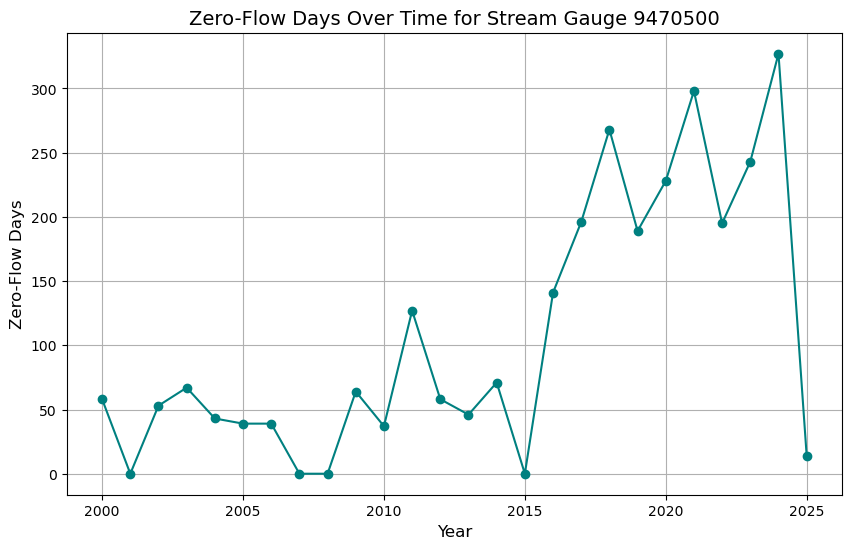

In [47]:
# Filter for a specific stream gauge
stream_id = 9470500  # Replace with the actual stream ID you want
stream_data = zero_flow_counts[zero_flow_counts['ID'] == stream_id]

import matplotlib.pyplot as plt

# Plot zero-flow days over time
plt.figure(figsize=(10, 6))
plt.plot(stream_data['Year'], stream_data['Zero_Flow'], marker='o', linestyle='-', color='teal')

# Add labels, title, and grid
plt.title(f'Zero-Flow Days Over Time for Stream Gauge {stream_id}', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Zero-Flow Days', fontsize=12)
plt.grid(True)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Show the plot
plt.show()


In [31]:
# Filter for stream gauges with "San Pedro" in their names (case-insensitive)
filtered_keyword = merged_data[merged_data['Name'].str.contains('San Pedro', case=False, na=False)]

# Check the filtered result
filtered_keyword


,ID,Year,Zero_Flow,Agency,Name
1493,9470500,2000,58,USGS,"SAN PEDRO RIVER AT PALOMINAS, AZ."
1494,9470500,2001,0,USGS,"SAN PEDRO RIVER AT PALOMINAS, AZ."
1495,9470500,2002,53,USGS,"SAN PEDRO RIVER AT PALOMINAS, AZ."
1496,9470500,2003,67,USGS,"SAN PEDRO RIVER AT PALOMINAS, AZ."
1497,9470500,2004,43,USGS,"SAN PEDRO RIVER AT PALOMINAS, AZ."
...,...,...,...,...,...
1761,9472050,2021,310,USGS,"SAN PEDRO R AT REDINGTON BRIDGE NR REDINGTON, AZ"
1762,9472050,2022,288,USGS,"SAN PEDRO R AT REDINGTON BRIDGE NR REDINGTON, AZ"
1763,9472050,2023,339,USGS,"SAN PEDRO R AT REDINGTON BRIDGE NR REDINGTON, AZ"
1764,9472050,2024,313,USGS,"SAN PEDRO R AT REDINGTON BRIDGE NR REDINGTON, AZ"


In [33]:
filtered_keyword['Name'].unique()

array(['SAN PEDRO RIVER AT PALOMINAS, AZ.',
       'SAN PEDRO RIVER AT CHARLESTON, AZ',
       'SAN PEDRO RIVER NEAR TOMBSTONE, AZ',
       'SAN PEDRO RIVER AT ST DAVID, AZ',
       'SAN PEDRO R AT REDINGTON BRIDGE NR REDINGTON, AZ'], dtype=object)

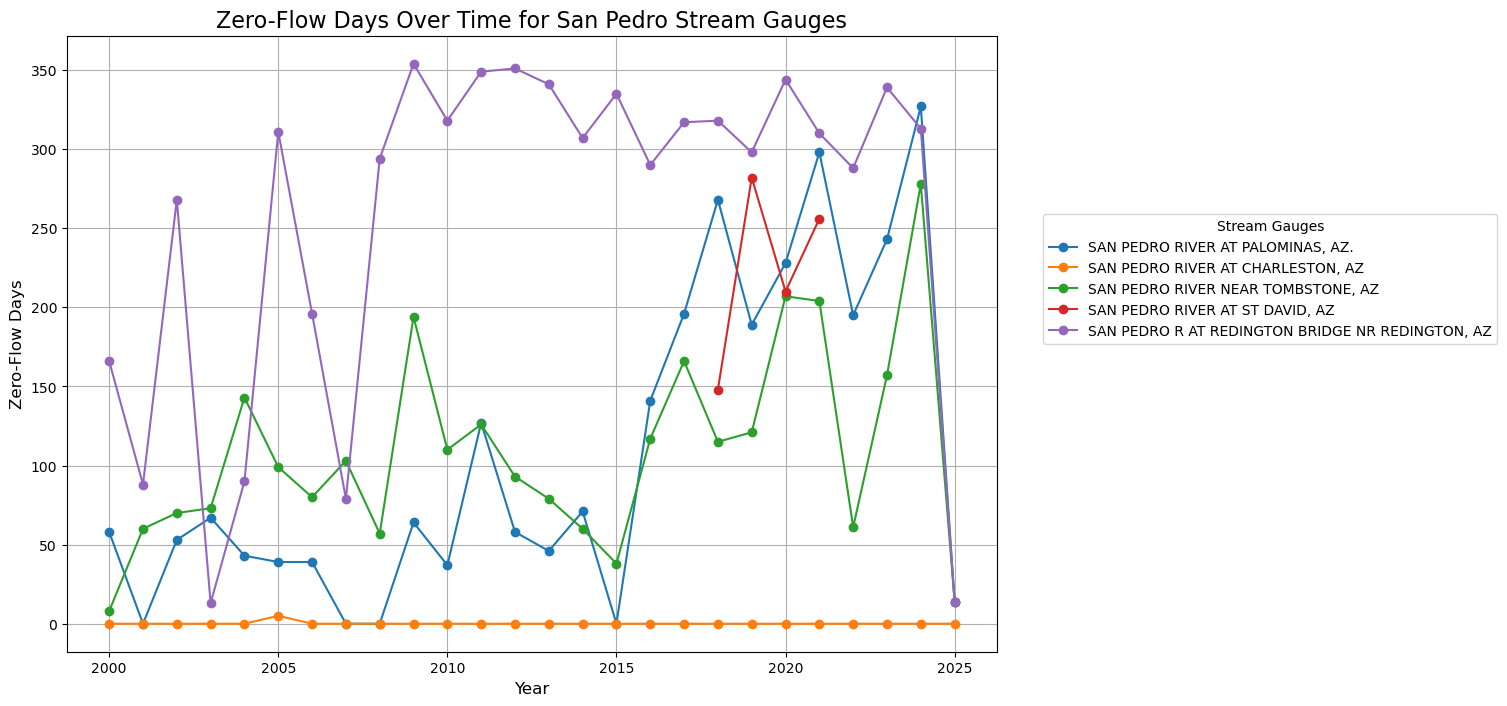

In [37]:
import matplotlib.pyplot as plt

# Set up the figure
plt.figure(figsize=(12, 8))

# Plot each gauge
for gauge_id, gauge_data in filtered_keyword.groupby('ID'):
    plt.plot(
        gauge_data['Year'], 
        gauge_data['Zero_Flow'], 
        marker='o', 
        label=gauge_data['Name'].iloc[0]  # Use the gauge name for the legend
    )

# Add labels, title, and legend
plt.title('Zero-Flow Days Over Time for San Pedro Stream Gauges', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Zero-Flow Days', fontsize=12)
plt.legend(title="Stream Gauges", loc=[1.05,0.5],fontsize=10)
plt.grid(True)

# Show the plot
plt.show()


In [41]:
# Filter for stream gauges with keyword in their names (case-insensitive)
keyword = "Gila River"
filtered_keyword = merged_data[merged_data['Name'].str.contains(keyword, case=False, na=False)]

# Check the filtered result
filtered_keyword


,ID,Year,Zero_Flow,Agency,Name
1195,9439000,2003,0,USGS,"GILA RIVER AT DUNCAN, AZ"
1196,9439000,2004,0,USGS,"GILA RIVER AT DUNCAN, AZ"
1197,9439000,2005,15,USGS,"GILA RIVER AT DUNCAN, AZ"
1198,9439000,2006,45,USGS,"GILA RIVER AT DUNCAN, AZ"
1199,9439000,2007,4,USGS,"GILA RIVER AT DUNCAN, AZ"
...,...,...,...,...,...
3906,9520500,2021,0,USGS,"GILA RIVER NEAR DOME, AZ"
3907,9520500,2022,0,USGS,"GILA RIVER NEAR DOME, AZ"
3908,9520500,2023,0,USGS,"GILA RIVER NEAR DOME, AZ"
3909,9520500,2024,0,USGS,"GILA RIVER NEAR DOME, AZ"


In [42]:
# See how many stream gauges that actually is
filtered_keyword['Name'].unique()

array(['GILA RIVER AT DUNCAN, AZ', 'GILA RIVER NEAR CLIFTON, AZ',
       'GILA RIVER AT HEAD OF SAFFORD VALLEY, NR SOLOMON,',
       'GILA RIVER AT CALVA, AZ.', 'GILA RIVER BELOW COOLIDGE DAM, AZ.',
       'GILA RIVER AT WINKELMAN, ARIZ.', 'GILA RIVER AT KELVIN, AZ.',
       'GILA RIVER AT ATTAWAY, AZ', 'GILA RIVER NEAR MARICOPA, AZ.',
       'GILA RIVER AT ESTRELLA PARKWAY, NEAR GOODYEAR, AZ',
       'GILA RIVER BELOW PAINTED ROCK DAM, AZ',
       'GILA RIVER NEAR DATELAND, AZ', 'GILA RIVER NEAR DOME, AZ'],
      dtype=object)

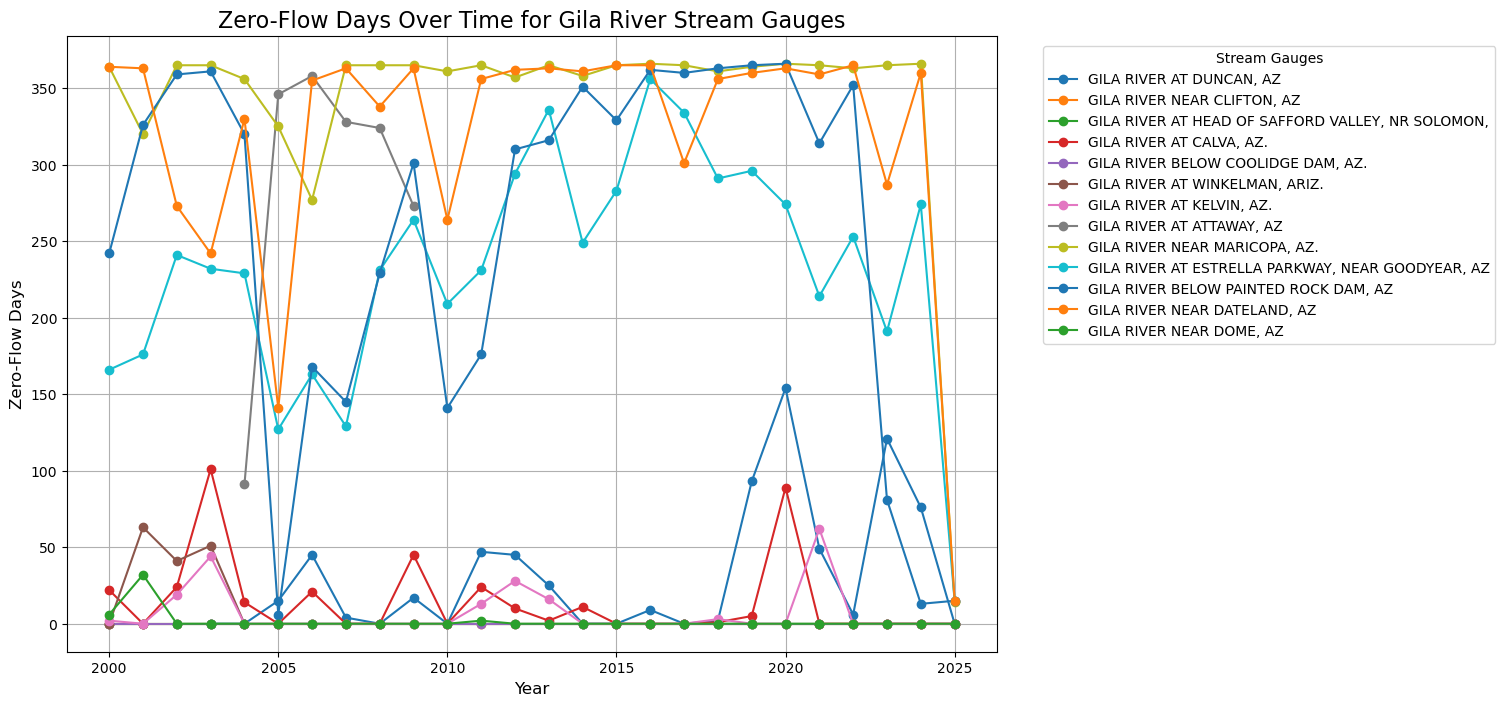

In [43]:
import matplotlib.pyplot as plt

# Set up the figure
plt.figure(figsize=(12, 8))

# Plot each gauge
for gauge_id, gauge_data in filtered_keyword.groupby('ID'):
    plt.plot(
        gauge_data['Year'], 
        gauge_data['Zero_Flow'], 
        marker='o', 
        label=gauge_data['Name'].iloc[0]  # Use the gauge name for the legend
    )

# Add labels, title, and legend
plt.title('Zero-Flow Days Over Time for '+keyword+' Stream Gauges', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Zero-Flow Days', fontsize=12)
plt.legend(title="Stream Gauges", loc=[1.05,0.5],fontsize=10)
plt.grid(True)

# Show the plot
plt.show()


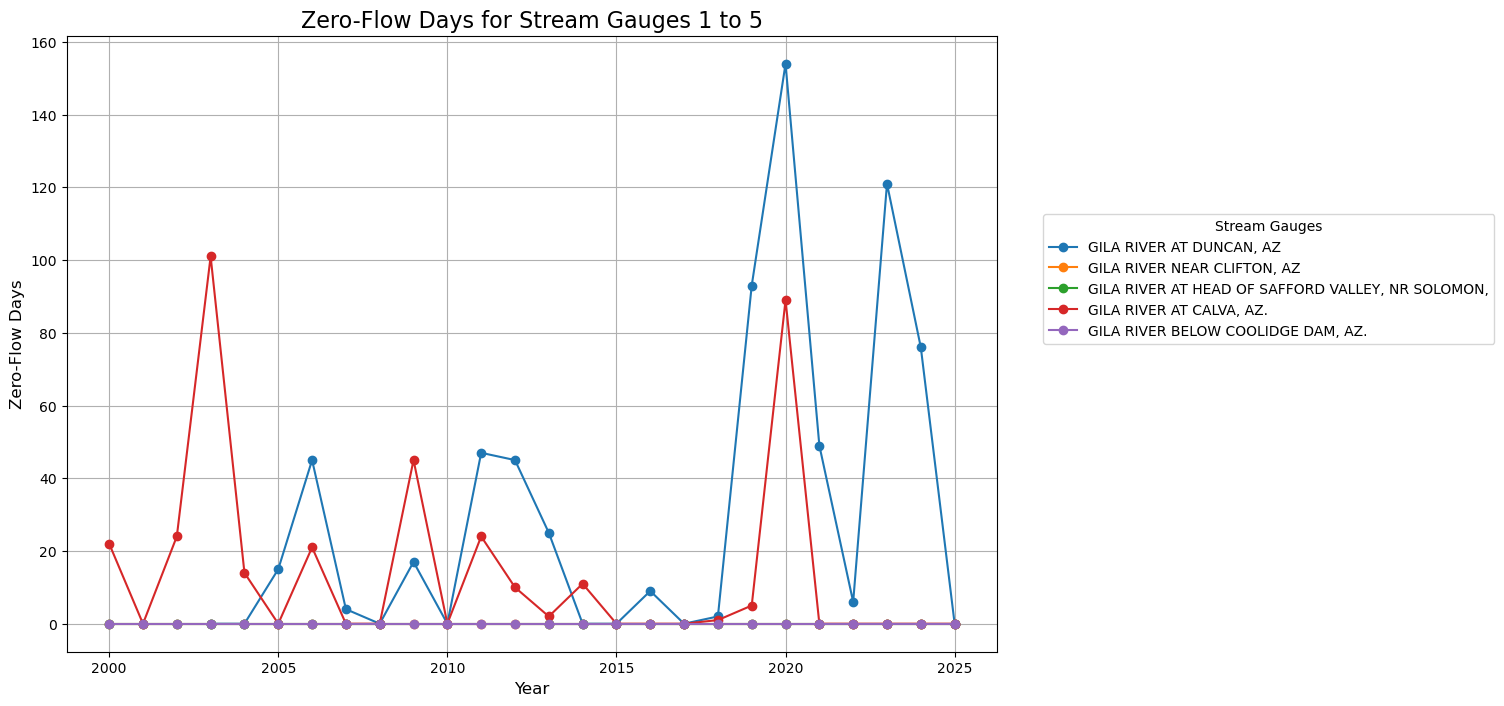

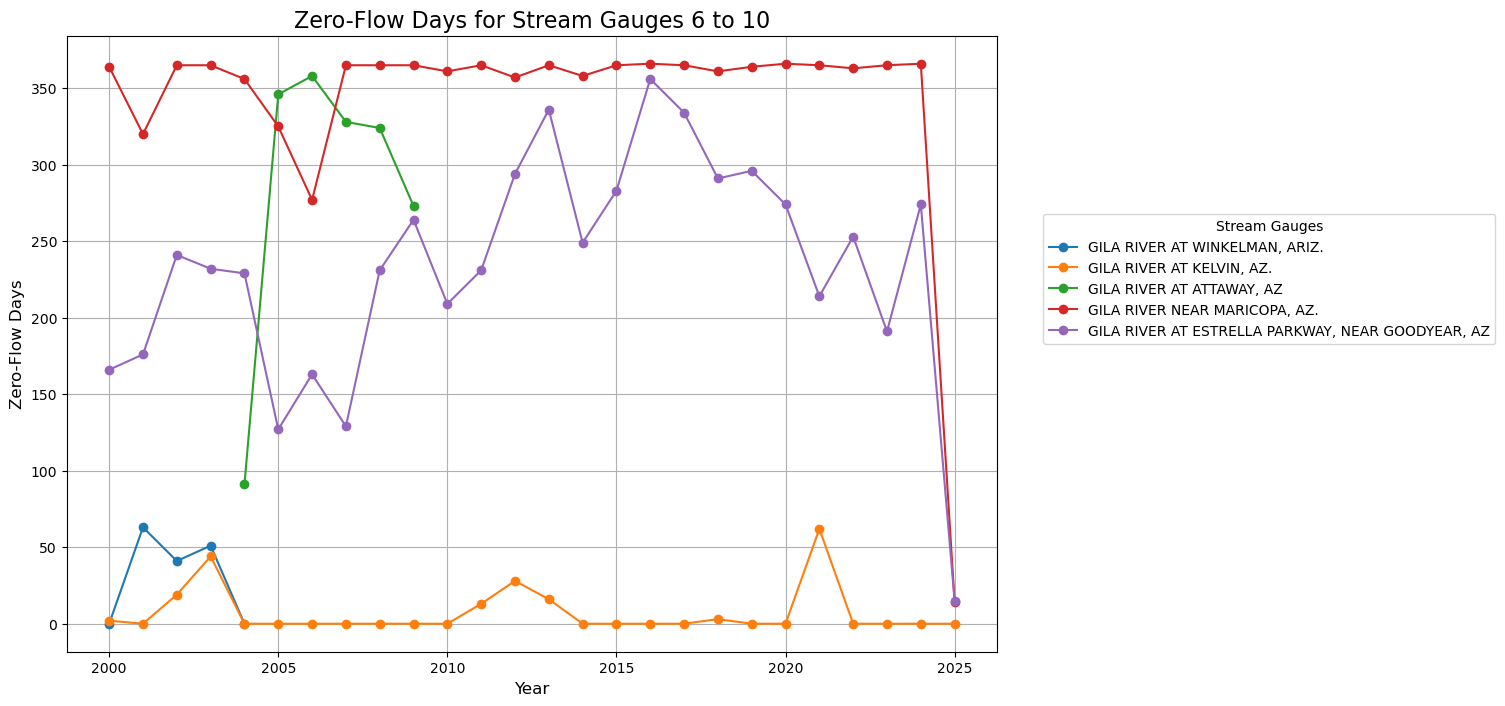

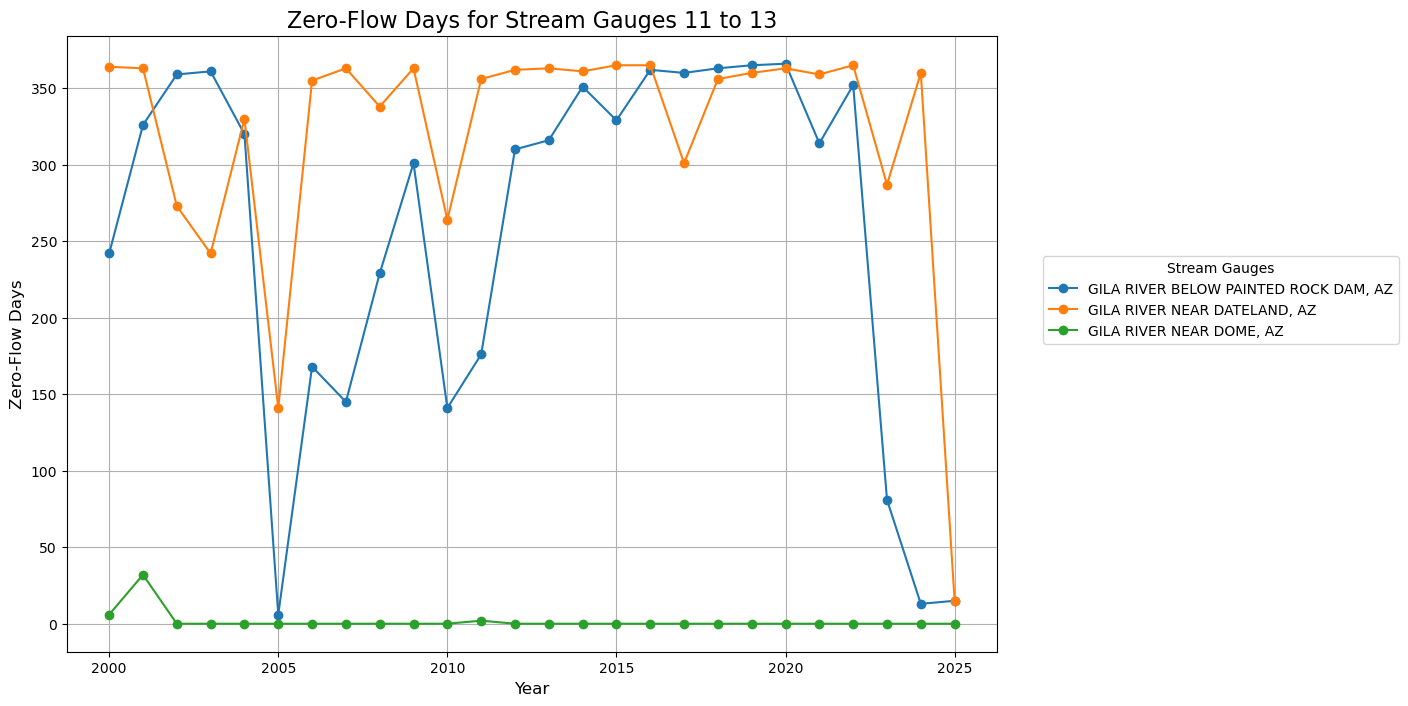

In [46]:
# Set the limit for gauges per plot
limit = 5

# Get a list of unique stream IDs
unique_gauges = filtered_keyword['ID'].unique()

# Loop through the gauges in chunks of the specified limit
for i in range(0, len(unique_gauges), limit):
    subset_gauges = unique_gauges[i:i+limit]  # Get the current chunk of gauges
    
    # Filter the data for these gauges
    subset_data = filtered_keyword[filtered_keyword['ID'].isin(subset_gauges)]
    
    # Plot the subset
    plt.figure(figsize=(12, 8))
    for gauge_id, gauge_data in subset_data.groupby('ID'):
        plt.plot(
            gauge_data['Year'], 
            gauge_data['Zero_Flow'], 
            marker='o', 
            label=gauge_data['Name'].iloc[0]
        )
    
    # Add labels, title, and legend
    plt.title(f'Zero-Flow Days for Stream Gauges {i+1} to {i+len(subset_gauges)}', fontsize=16)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Zero-Flow Days', fontsize=12)
    plt.legend(title="Stream Gauges",loc=[1.05,0.5], fontsize=10)
    plt.grid(True)
    
    # Show the plot
    plt.show()


<Axes: >

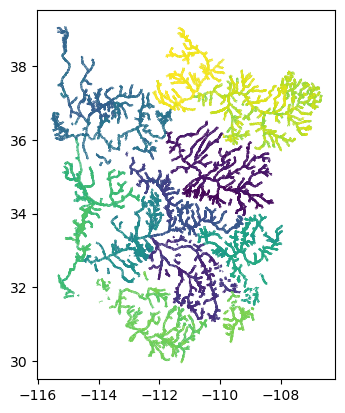

In [3]:
# Read in the shapefile

# filename_shapeile = 'georeg_reproject_fixed.shp'
filename_shapeile = '/flowlines_order4plus.shp'
# filepath = os.path.join(shapepath, filename_shapeile)
filepath = os.path.join(outputpath+filename_shapeile)
shapefile = gp.read_file(filepath)
shapefile.plot(cmap='viridis')


Take a look at the columns and variables

In [6]:
shapefile.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 92012 entries, 0 to 92011
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   permanent_  92012 non-null  object  
 1   gnis_name   53735 non-null  object  
 2   reachcode   92012 non-null  object  
 3   streamorde  92012 non-null  int64   
 4   ID          10230 non-null  object  
 5   huc4        92012 non-null  object  
 6   huc_name    92012 non-null  object  
 7   geometry    92012 non-null  geometry
dtypes: geometry(1), int64(1), object(6)
memory usage: 5.6+ MB


In [ ]:
# test = shapefile['ID'].dropna()
test = shapefile.dropna(subset=['ID'])
test

,permanent_,gnis_name,reachcode,streamorde,ID,huc4,huc_name,geometry
18,149135801,Silver Creek,15020005000015,7,343604110041700,1502,Little Colorado,"LINESTRING Z (-110.07317 34.60113 0.00000, -11..."
19,149135801,Silver Creek,15020005000015,7,343604110041700,1502,Little Colorado,"LINESTRING Z (-110.07317 34.60113 0.00000, -11..."
23,149136047,Cottonwood Wash,15020005001637,6,09393400,1502,Little Colorado,"LINESTRING Z (-110.10498 34.50232 0.00000, -11..."
24,149136047,Cottonwood Wash,15020005001637,6,09393400,1502,Little Colorado,"LINESTRING Z (-110.10498 34.50232 0.00000, -11..."
32,149135800,Silver Creek,15020005000015,7,343604110041700,1502,Little Colorado,"LINESTRING Z (-110.08325 34.59153 0.00000, -11..."
...,...,...,...,...,...,...,...,...
91808,79246743,Warm Creek,14070006008846,5,370333111262700,1407,Upper Colorado-Dirty Devil,"LINESTRING Z (-111.44609 37.06088 0.00000, -11..."
91816,79072388,Paria River,14070007000157,6,372526112020201,1407,Upper Colorado-Dirty Devil,"LINESTRING Z (-112.03018 37.44717 0.00000, -11..."
91817,79072388,Paria River,14070007000157,6,372526112020201,1407,Upper Colorado-Dirty Devil,"LINESTRING Z (-112.03018 37.44717 0.00000, -11..."
91820,79072180,Paria River,14070007000157,6,372526112020201,1407,Upper Colorado-Dirty Devil,"LINESTRING Z (-112.03368 37.45518 0.00000, -11..."


In [16]:
# Keep only rows where Combo_ID is fully numeric
test = test[test['ID'].str.isnumeric()]

# %% Converting ID to int
test['ID'] = test['ID'].astype(np.int64, errors = 'raise')
test.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 10073 entries, 18 to 91821
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   permanent_  10073 non-null  object  
 1   gnis_name   9427 non-null   object  
 2   reachcode   10073 non-null  object  
 3   streamorde  10073 non-null  int64   
 4   ID          10073 non-null  int64   
 5   huc4        10073 non-null  object  
 6   huc_name    10073 non-null  object  
 7   geometry    10073 non-null  geometry
dtypes: geometry(1), int64(2), object(5)
memory usage: 708.3+ KB


c:\Users\det19\.conda\envs\azgwspatialanalysis\lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<Axes: >

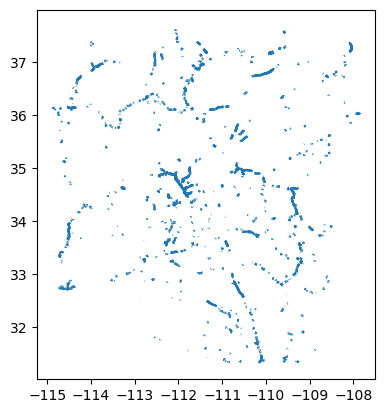

In [19]:
test.plot()

In [5]:
# Define some things about your file

StudyArea = "HUC4s"
# Naming_col = "Name"
Naming_col = "huc4"

In [17]:
# Pull out the columns you need
# Use this for subbasins:
# reg_list = static_geo[['Combo_ID', Naming_col+'_right','WELL_DEPTH','WELL_TYPE_']]

# Use this or cities:
reg_list = test[['ID', Naming_col,'gnis_name']]
# reg_list

# %% Converting Combo_ID to int
# reg_list['Combo_ID'] = reg_list['Combo_ID'].astype(np.int64, errors = 'raise')

In [15]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4438 entries, 0 to 4437
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  4438 non-null   int64 
 1   ID          4438 non-null   int64 
 2   Year        4438 non-null   int64 
 3   Zero_Flow   4438 non-null   int64 
 4   Agency      4411 non-null   object
 5   Name        4411 non-null   object
dtypes: int64(4), object(2)
memory usage: 208.2+ KB


In [18]:
# Merging the Timeseries and the shapefile static database
combo = merged_data.merge(reg_list, how="inner")
combo.info()

# %% set index to Combo_ID
combo.set_index('ID', inplace=True)
combo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26995 entries, 0 to 26994
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  26995 non-null  int64 
 1   ID          26995 non-null  int64 
 2   Year        26995 non-null  int64 
 3   Zero_Flow   26995 non-null  int64 
 4   Agency      26995 non-null  object
 5   Name        26995 non-null  object
 6   huc4        26995 non-null  object
 7   gnis_name   25379 non-null  object
dtypes: int64(4), object(4)
memory usage: 1.6+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 26995 entries, 9379025 to 9537500
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  26995 non-null  int64 
 1   Year        26995 non-null  int64 
 2   Zero_Flow   26995 non-null  int64 
 3   Agency      26995 non-null  object
 4   Name        26995 non-null  object
 5   huc4        26995 non-null  object
 6   gnis_n

In [20]:
combo

,Unnamed: 0,Year,Zero_Flow,Agency,Name,huc4,gnis_name
ID,,,,,,,
9379025,0,2000,201,USGS,"CHINLE CREEK AT CHINLE, AZ",1408,NaN
9379025,0,2000,201,USGS,"CHINLE CREEK AT CHINLE, AZ",1408,NaN
9379025,1,2001,201,USGS,"CHINLE CREEK AT CHINLE, AZ",1408,NaN
9379025,1,2001,201,USGS,"CHINLE CREEK AT CHINLE, AZ",1408,NaN
9379025,2,2002,244,USGS,"CHINLE CREEK AT CHINLE, AZ",1408,NaN
...,...,...,...,...,...,...,...
9537500,4406,2023,348,USGS,"WHITEWATER DRAW NEAR DOUGLAS, AZ.",1508,NaN
9537500,4407,2024,302,USGS,"WHITEWATER DRAW NEAR DOUGLAS, AZ.",1508,NaN
9537500,4407,2024,302,USGS,"WHITEWATER DRAW NEAR DOUGLAS, AZ.",1508,NaN


In [28]:
huc_streams = pd.pivot_table(combo, index=["huc4"], columns=["Year"], values=["Zero_Flow"], dropna=False, aggfunc=np.mean)
huc_streams

Zero_Flow                                                              \
Year        2000        2001        2002        2003        2004        2005   
huc4                                                                           
1407    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
1408  138.857143  126.142857  145.285714  131.285714  128.571429  119.428571   
1501    0.000000    0.621118    1.490683    2.374101    0.000000    0.000000   
1502  165.139130  141.015385  149.888060  139.258993  146.683453  141.753425   
1503   42.916667   76.214286   68.571429   37.428571   27.375000   12.424242   
1504    7.652174    0.000000    8.347826   34.628571    4.800000    0.214286   
1505  108.076271   90.436975  128.655462  119.184211  116.008264  137.382609   
1506   18.448276   18.170569   31.671096   25.950980   22.964286   12.212903   
1507  126.591398  123.208791  181.329670  144.615385  136.703297   38.450549   
1508  220.666667   67.333333   49.333333  178.666667  274.000000  251.333333   

                                                      ...              \
Year        2006        2007        2008        2009  ...        2016   
huc4                                                  ...               
1407    0.000000    0.000000    0.000000    0.000000  ...    0.000000   
1408  118.800000   49.000000   85.000000  118.000000  ...   54.000000   
1501    0.373134    0.000000    0.755396   13.093525  ...   13.165468   
1502  132.363636  156.414966  130.661202  170.285714  ...  113.664000   
1503    3.030303    3.870968    6.606061    6.486486  ...   52.794118   
1504    7.842857    0.057143    0.000000   18.913793  ...    0.128571   
1505  123.395652  109.717391  125.556522  143.513043  ...  134.958140   
1506   22.929530   19.335443   16.028481   23.588608  ...   31.685358   
1507   90.164835  105.653061  105.755102  119.744898  ...  135.826531   
1508  208.000000  195.333333  209.333333  256.333333  ...  288.666667   

                                                                              \
Year        2017        2018        2019        2020        2021        2022   
huc4                                                                           
1407    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
1408   36.000000   87.000000  135.000000  210.000000    3.000000   56.500000   
1501   56.035971   19.793814   18.711340   18.865979   19.226804   16.494845   
1502  120.824000  130.312000  115.048000  115.572519  111.032000   84.736000   
1503   51.117647   19.029412   37.382353   15.588235   11.470588   12.852941   
1504    0.000000    0.282609    2.315217   24.891304    6.750000   21.260000   
1505  138.511628  143.590698  140.273128  136.709251  129.167401  105.321586   
1506   26.978193   71.084112   24.411215   31.118380   49.937695   35.906542   
1507  128.551020  169.747253  104.846154  147.241758  189.098901  157.450549   
1508  293.333333  245.333333  295.000000  331.333333  248.000000  166.666667   

                                         
Year        2023        2024       2025  
huc4                                     
1407    0.000000    0.000000   0.000000  
1408  159.000000  168.500000   7.000000  
1501   16.907216   17.989691   0.721649  
1502   79.560000   88.712000   5.675676  
1503   17.088235   18.117647   0.411765  
1504   26.350000   25.480000   1.120000  
1505  145.422907  153.061674   6.907489  
1506   19.398754   38.710280   3.099010  
1507  108.857143  147.725275   7.780220  
1508  292.000000  321.000000  15.000000  

[10 rows x 26 columns]

In [29]:
huc_streams.index.name = None
huc_streams

Zero_Flow                                                              \
Year        2000        2001        2002        2003        2004        2005   
1407    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
1408  138.857143  126.142857  145.285714  131.285714  128.571429  119.428571   
1501    0.000000    0.621118    1.490683    2.374101    0.000000    0.000000   
1502  165.139130  141.015385  149.888060  139.258993  146.683453  141.753425   
1503   42.916667   76.214286   68.571429   37.428571   27.375000   12.424242   
1504    7.652174    0.000000    8.347826   34.628571    4.800000    0.214286   
1505  108.076271   90.436975  128.655462  119.184211  116.008264  137.382609   
1506   18.448276   18.170569   31.671096   25.950980   22.964286   12.212903   
1507  126.591398  123.208791  181.329670  144.615385  136.703297   38.450549   
1508  220.666667   67.333333   49.333333  178.666667  274.000000  251.333333   

                                                      ...              \
Year        2006        2007        2008        2009  ...        2016   
1407    0.000000    0.000000    0.000000    0.000000  ...    0.000000   
1408  118.800000   49.000000   85.000000  118.000000  ...   54.000000   
1501    0.373134    0.000000    0.755396   13.093525  ...   13.165468   
1502  132.363636  156.414966  130.661202  170.285714  ...  113.664000   
1503    3.030303    3.870968    6.606061    6.486486  ...   52.794118   
1504    7.842857    0.057143    0.000000   18.913793  ...    0.128571   
1505  123.395652  109.717391  125.556522  143.513043  ...  134.958140   
1506   22.929530   19.335443   16.028481   23.588608  ...   31.685358   
1507   90.164835  105.653061  105.755102  119.744898  ...  135.826531   
1508  208.000000  195.333333  209.333333  256.333333  ...  288.666667   

                                                                              \
Year        2017        2018        2019        2020        2021        2022   
1407    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
1408   36.000000   87.000000  135.000000  210.000000    3.000000   56.500000   
1501   56.035971   19.793814   18.711340   18.865979   19.226804   16.494845   
1502  120.824000  130.312000  115.048000  115.572519  111.032000   84.736000   
1503   51.117647   19.029412   37.382353   15.588235   11.470588   12.852941   
1504    0.000000    0.282609    2.315217   24.891304    6.750000   21.260000   
1505  138.511628  143.590698  140.273128  136.709251  129.167401  105.321586   
1506   26.978193   71.084112   24.411215   31.118380   49.937695   35.906542   
1507  128.551020  169.747253  104.846154  147.241758  189.098901  157.450549   
1508  293.333333  245.333333  295.000000  331.333333  248.000000  166.666667   

                                         
Year        2023        2024       2025  
1407    0.000000    0.000000   0.000000  
1408  159.000000  168.500000   7.000000  
1501   16.907216   17.989691   0.721649  
1502   79.560000   88.712000   5.675676  
1503   17.088235   18.117647   0.411765  
1504   26.350000   25.480000   1.120000  
1505  145.422907  153.061674   6.907489  
1506   19.398754   38.710280   3.099010  
1507  108.857143  147.725275   7.780220  
1508  292.000000  321.000000  15.000000  

[10 rows x 26 columns]

In [30]:
huc_streams.to_csv(outputpath+'/huc_average_flow.csv')

In [66]:
# Now to read in that file
filename_ts = '/huc_average_flow.csv'
annual_db = pd.read_csv(outputpath+filename_ts, header=1, index_col=0)

#Block to do some formatting
annual_db = annual_db[1:168102]
annual_db.index = annual_db.index.astype('int64')
annual_db2 = annual_db.reset_index(inplace=True)
annual_db2 = annual_db.rename(columns = {'Year':'index'})
annual_db2.set_index('index', inplace=True)
annual_db2.head()

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025
index,,,,,,,,,,,,,,,,,,,,,
1408,138.857143,126.142857,145.285714,131.285714,128.571429,119.428571,118.800000,49.000000,85.000000,118.000000,...,54.000000,36.000000,87.000000,135.000000,210.000000,3.000000,56.500000,159.000000,168.500000,7.000000
1501,0.000000,0.621118,1.490683,2.374101,0.000000,0.000000,0.373134,0.000000,0.755396,13.093525,...,13.165468,56.035971,19.793814,18.711340,18.865979,19.226804,16.494845,16.907216,17.989691,0.721649
1502,165.139130,141.015385,149.888060,139.258993,146.683453,141.753425,132.363636,156.414966,130.661202,170.285714,...,113.664000,120.824000,130.312000,115.048000,115.572519,111.032000,84.736000,79.560000,88.712000,5.675676
1503,42.916667,76.214286,68.571429,37.428571,27.375000,12.424242,3.030303,3.870968,6.606061,6.486486,...,52.794118,51.117647,19.029412,37.382353,15.588235,11.470588,12.852941,17.088235,18.117647,0.411765
1504,7.652174,0.000000,8.347826,34.628571,4.800000,0.214286,7.842857,0.057143,0.000000,18.913793,...,0.128571,0.000000,0.282609,2.315217,24.891304,6.750000,21.260000,26.350000,25.480000,1.120000


In [72]:
i = annual_db2.copy()
# del i['WELL_DEPTH']
f = i.transpose()
# f
f.reset_index(inplace=True)

f['index'] = pd.to_numeric(f['index'])
f['index'] = f['index'].astype(int)
f.set_index('index', inplace=True)
f.info()
f.index.name = None
cat_wl2 = f
cat_wl2

<class 'pandas.core.frame.DataFrame'>
Index: 26 entries, 2000 to 2025
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1408    26 non-null     float64
 1   1501    26 non-null     float64
 2   1502    26 non-null     float64
 3   1503    26 non-null     float64
 4   1504    26 non-null     float64
 5   1505    26 non-null     float64
 6   1506    26 non-null     float64
 7   1507    26 non-null     float64
 8   1508    26 non-null     float64
dtypes: float64(9)
memory usage: 1.9 KB


index,1408,1501,1502,1503,1504,1505,1506,1507,1508
2000,138.857143,0.000000,165.139130,42.916667,7.652174,108.076271,18.448276,126.591398,220.666667
2001,126.142857,0.621118,141.015385,76.214286,0.000000,90.436975,18.170569,123.208791,67.333333
2002,145.285714,1.490683,149.888060,68.571429,8.347826,128.655462,31.671096,181.329670,49.333333
2003,131.285714,2.374101,139.258993,37.428571,34.628571,119.184211,25.950980,144.615385,178.666667
2004,128.571429,0.000000,146.683453,27.375000,4.800000,116.008264,22.964286,136.703297,274.000000
2005,119.428571,0.000000,141.753425,12.424242,0.214286,137.382609,12.212903,38.450549,251.333333
2006,118.800000,0.373134,132.363636,3.030303,7.842857,123.395652,22.929530,90.164835,208.000000
2007,49.000000,0.000000,156.414966,3.870968,0.057143,109.717391,19.335443,105.653061,195.333333
2008,85.000000,0.755396,130.661202,6.606061,0.000000,125.556522,16.028481,105.755102,209.333333
2009,118.000000,13.093525,170.285714,6.486486,18.913793,143.513043,23.588608,119.744898,256.333333


In [69]:
Min_year_of_Study = 2000
Max_year_of_Study = 2024

# Water Analysis period
wlanalysis_period = cat_wl2[(cat_wl2.index>=Min_year_of_Study)&(cat_wl2.index<=Max_year_of_Study)]
wlanalysis_period.head(25)

index,1408,1501,1502,1503,1504,1505,1506,1507,1508
2000,138.857143,0.000000,165.139130,42.916667,7.652174,108.076271,18.448276,126.591398,220.666667
2001,126.142857,0.621118,141.015385,76.214286,0.000000,90.436975,18.170569,123.208791,67.333333
2002,145.285714,1.490683,149.888060,68.571429,8.347826,128.655462,31.671096,181.329670,49.333333
2003,131.285714,2.374101,139.258993,37.428571,34.628571,119.184211,25.950980,144.615385,178.666667
2004,128.571429,0.000000,146.683453,27.375000,4.800000,116.008264,22.964286,136.703297,274.000000
2005,119.428571,0.000000,141.753425,12.424242,0.214286,137.382609,12.212903,38.450549,251.333333
2006,118.800000,0.373134,132.363636,3.030303,7.842857,123.395652,22.929530,90.164835,208.000000
2007,49.000000,0.000000,156.414966,3.870968,0.057143,109.717391,19.335443,105.653061,195.333333
2008,85.000000,0.755396,130.661202,6.606061,0.000000,125.556522,16.028481,105.755102,209.333333
2009,118.000000,13.093525,170.285714,6.486486,18.913793,143.513043,23.588608,119.744898,256.333333


In [74]:
wlanalysis_period.columns

Index([1408, 1501, 1502, 1503, 1504, 1505, 1506, 1507, 1508], dtype='object', name='index')

In [75]:
wlanalysis_period.columns = wlanalysis_period.columns.astype(str)

                1501         1502         1503        1504         1505  \
slope       1.098858    -2.770066    -0.747915    0.348773     1.272171   
int     -2199.258543  5698.422279  1530.055618 -693.316856 -2427.327148   
rsq         0.461948     0.581422     0.069192    0.060352     0.250420   
p_val       0.000186     0.000009     0.203944    0.236535     0.010845   
std_err     0.247282     0.490082     0.571994    0.286957     0.458940   
mean       11.644597   125.049205    25.251078    8.415352   132.280610   
var       135.923126   686.265145   420.391331  104.809106   336.066497   
sum       291.114914  3126.230118   631.276954  210.383810  3307.015244   

                1506         1507          1508  
slope       0.984698     1.097279      5.108718  
int     -1951.509199 -2081.344807 -10041.087179  
rsq         0.197063     0.060075      0.250293  
p_val       0.026219     0.237646      0.010869  
std_err     0.414455     0.905007      1.843611  
mean       29.702210   1

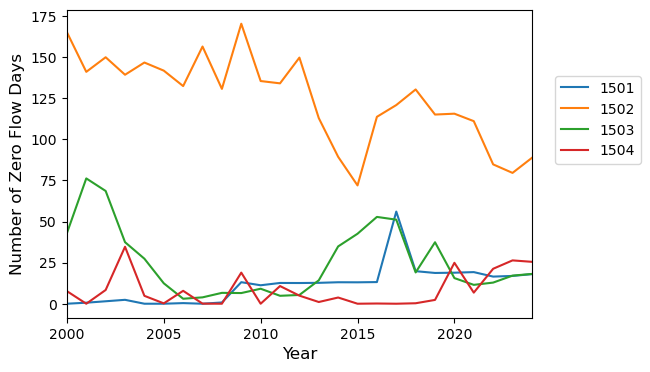

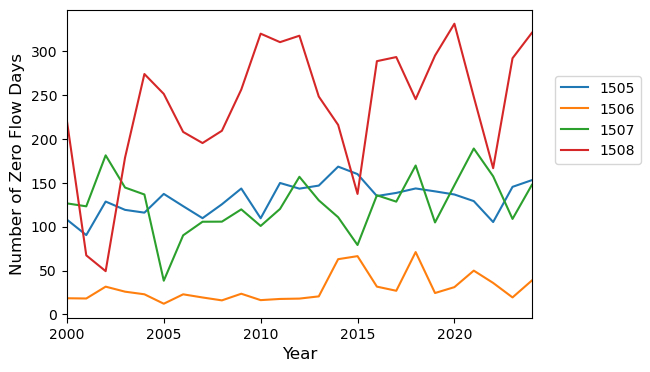

In [79]:
# Define dataset
ds = wlanalysis_period[['1501','1502','1503','1504','1505','1506','1507','1508']]
min_yr = 2000
mx_yr = 2024
Name = "mean_" + StudyArea

betterlabels = ['1501','1502','1503','1504','1505','1506','1507','1508']

ylim = 800

f = ds[(ds.index >= min_yr) & (ds.index <= mx_yr)]
column_list = ds.columns.tolist()

stats = pd.DataFrame()

# Compute statistics
for col in column_list:
    df = f[col]
    y = np.array(df.values, dtype=float)
    x = np.array(df.index.values, dtype=float)  

    # Linear regression stats
    slope, intercept, r_value, p_value, std_err = sp.linregress(x, y)

    # Append statistics
    stats = stats._append({
        'slope': slope, 
        'int': intercept, 
        'rsq': r_value * r_value, 
        'p_val': p_value, 
        'std_err': std_err, 
        'mean': np.mean(y),
        'var': np.var(y),
        'sum': np.sum(y)
    }, ignore_index=True)

stats.index = betterlabels
stats1 = stats.transpose()
print(stats1)

# ---- Plot in Groups of 4 ----
batch_size = 4
for i in range(0, len(column_list), batch_size):
    fig, ax = plt.subplots(figsize=(6, 4))

    for col in column_list[i:i+batch_size]:  # Select four at a time
        ax.plot(ds[col], label=col)  
    
    # Formatting
    # ax.set_ylim(ylim, 0)
    ax.set_xticks(np.arange(min_yr, mx_yr + 1, 5))
    ax.set_xlim(min_yr, mx_yr)
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Number of Zero Flow Days', fontsize=12)
    ax.legend(loc=[1.05,0.5])

    # Show each figure before saving
    plt.show()
